# FOIAOnline Analysis

The [Freedom of Information Act]() clearinghouse foiaonline.gov was turned off on September 30, 2023. See [After a decade, FOIAonline is shutting down. What’s next for FOIA requestors?](https://www.muckrock.com/news/archives/2023/sep/26/foiaonline-shutting-down/) MuckRock article for some of the history and details.

Unfortunately the content of the site is largely accessible by submitting a search in a form, which can present problems for web archiving without some kind of manual intervention. This notebook explores how some data about requests that have been made can be collected from the site, and what sort of coverage is in the Internet Archive's Wayback Machine.

## Collected JSON Data

The [pull.py](pull.py) utility will collect data from FOIAOnline Advanced Search form (while it is online), week by week, and then write out a line oriented JSON file of the results from the API that the form is using. Once it's run the `data.jsonl` file can be read in.

In [ ]:
import pathlib
import pandas

if pathlib.Path('data.jsonl.gz').is_file():
    data_file = 'data.jsonl.gz'
else:
    data_file = 'https://github.com/edsu/foiaonline/raw/main/data.jsonl.gz'

df = pandas.read_json(data_file, lines=True, convert_dates=['closedDate', 'received'])
df

In [2]:
df.columns

Index(['additionalDisposition', 'agency', 'agencyAcronym', 'agencyOrgChain',
       'clockDays', 'closedDate', 'description', 'descriptionFilter',
       'descriptionModified', 'due', 'exemptionsUsed', 'finalDisposition',
       'id', 'originalTrackingNumber', 'otherDisposition', 'parentType',
       'phase', 'privateFlag', 'received', 'recordAuthor',
       'recordExemptionsUsed', 'recordFileFormat', 'recordId', 'recordName',
       'recordReleaseDate', 'recordRetentionPeriod', 'recordSize',
       'reportingYear', 'requestType', 'requester', 'requesterOrg',
       'trackingNumber', 'type', 'dispositionsUsed', 'userCaseFileRequester',
       '_score'],
      dtype='object')

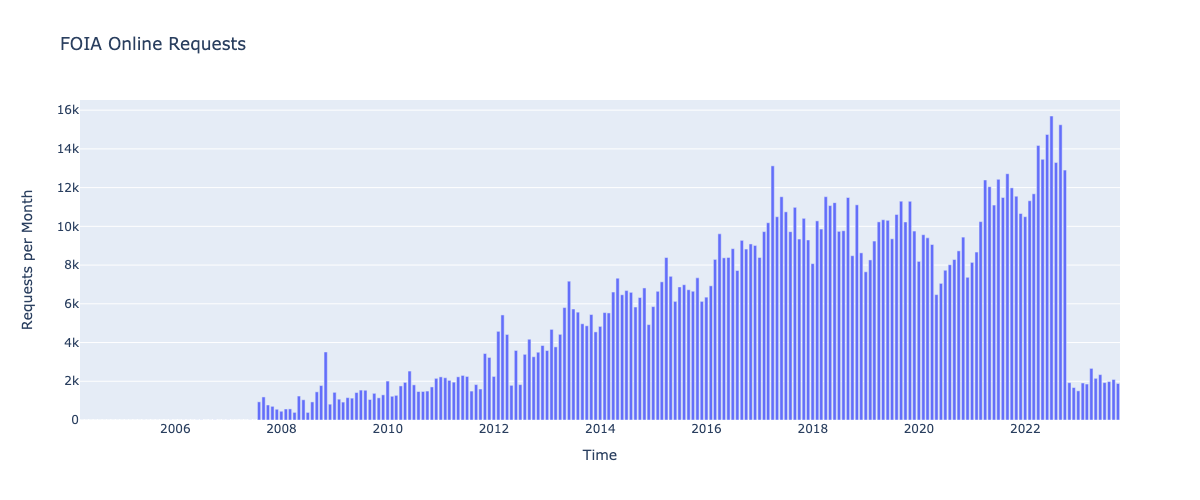

In [99]:
from plotly import express as px

monthly_counts = df.set_index('received').resample('M').agency.agg('count')

fig = px.bar(monthly_counts, width=1200, height=500, title='FOIA Online Requests')
fig.update_layout(showlegend=False, yaxis_title='Requests per Month', xaxis_title='Time')

fig.show('png')

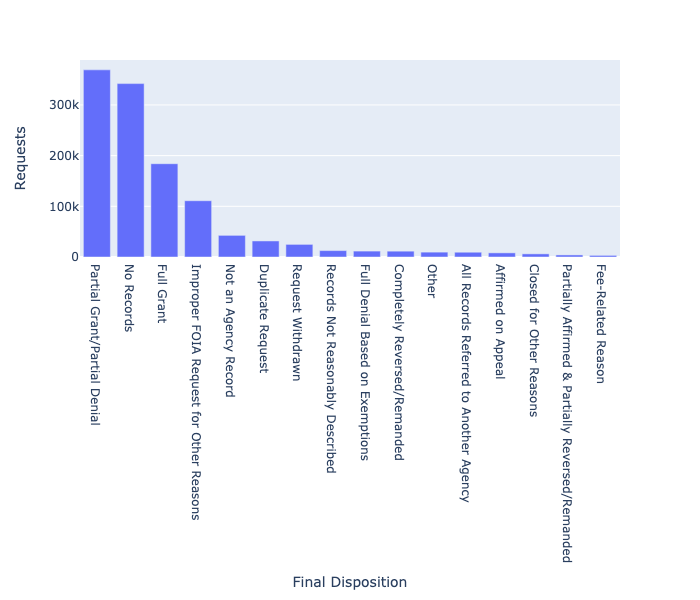

In [100]:
fig = px.bar(df.value_counts('finalDisposition'), height=600, labels={'finalDisposition': 'Final Disposition', 'value': 'Requests'})
fig.update_layout(showlegend=False)
fig.show('png')

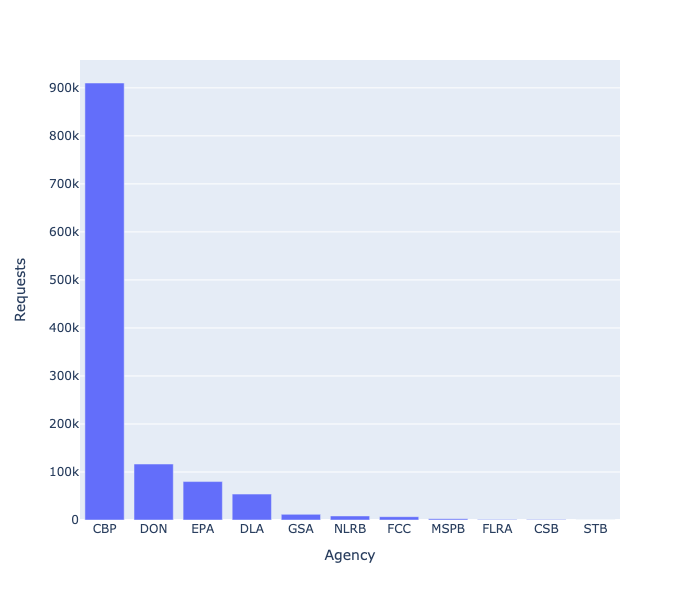

In [101]:
fig = px.bar(df.value_counts('agency'), height=600, labels={'agency': 'Agency', 'value': 'Requests'})
fig.update_layout(showlegend=False)
fig.show('png')

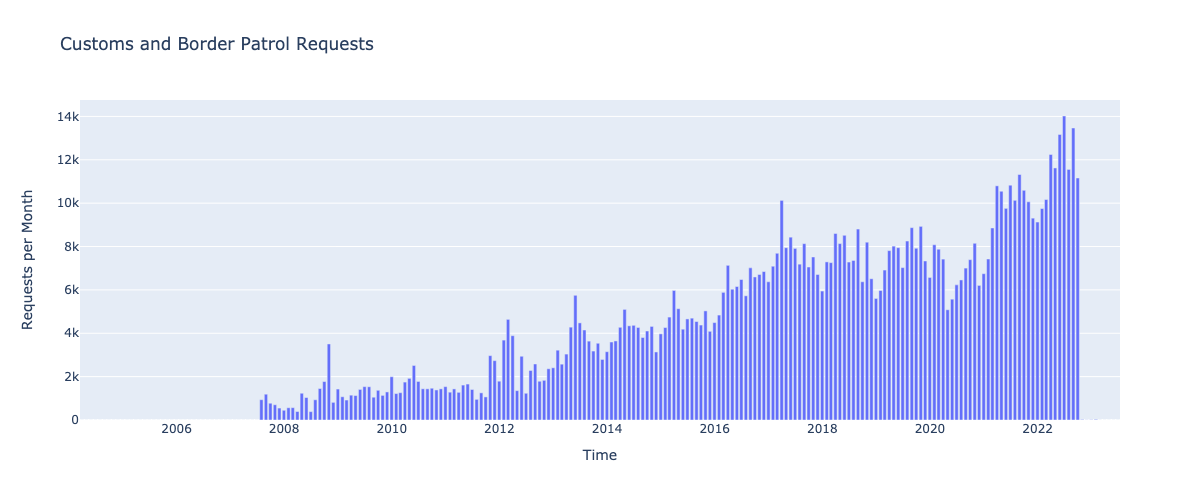

In [102]:
cbp_monthly_counts = df[df.agency == 'CBP'].set_index('received').resample('M').agency.agg('count')

fig = px.bar(cbp_monthly_counts, width=1200, height=500, title='Customs and Border Patrol Requests')
fig.update_layout(showlegend=False, yaxis_title='Requests per Month', xaxis_title='Time')

fig.show('png')

In [85]:
df.value_counts('requesterOrg')[0:100]

requesterOrg
Under Agency Review                    849592
Alexandra Lozano Immigration Law         2894
JGB Enterprises, Inc.                    2341
Consumer Law Group, LLC                  2282
Day & Day, Inc.                          2163
                                        ...  
Synergetic Technologies Group, Inc.       325
Kennedy Holden Law Firm, LLP              324
Now Electronics, inc.                     323
C.R. Wannamaker Law PLLC                  322
Specialized Metals, Inc.                  322
Name: count, Length: 100, dtype: int64

In [98]:
df[df.description != "The Description of this request is under agency review."][['trackingNumber', 'description']]

,trackingNumber,description
4,EPA-HQ-2005-000002,Recent collective bargaining unit agreement(s)...
5,EPA-HQ-2005-000004,"Appointment, finances, ethics, etc., related t..."
6,EPA-HQ-2005-000003,2004 Memorandum of Agreement and Data Call Ins...
9,EPA-HQ-2006-000009,Appeal of withholding of emails. Note: the sec...
10,EPA-HQ-2006-000011,Appeal of no records response regarding EPA no...
...,...,...
1192648,NLRB-2023-002286,I am requesting an electronic copy of any reco...
1192678,NLRB-2023-002268,I am trying to locate a representation case in...
1192710,NLRB-2023-002274,"All records in Rowell Chemical Corporation, Ca..."
1192721,NLRB-2023-002273,All records pertaining to any representation c...


## Wayback Machine

How much of [foiaonline.gov](https://foiaonline.gov) is archived in the Internet Archive [Wayback Machine](https://web.archive.org)? It's hard to say not knowing how many FOIA requests have been made exactly. But we can look to see how many unique pages are stored in Wayback, and make an educated guess.


In [26]:
import wayback

def get_snapshots():
    wb = wayback.WaybackClient()
    for record in wb.search('foiaonline.gov/*'):
        yield [record.timestamp, record.url]

snapshots = pandas.DataFrame(get_snapshots(), columns=['timestamp', 'url'])
snapshots

,timestamp,url
0,2018-07-17 19:39:07+00:00,https://www.foiaonline.gov/
1,2018-07-17 19:39:23+00:00,https://www.foiaonline.gov/
2,2018-07-17 21:56:00+00:00,https://www.foiaonline.gov/
3,2018-07-25 09:58:02+00:00,https://www.foiaonline.gov/
4,2018-07-26 00:48:32+00:00,https://www.foiaonline.gov/
...,...,...
1348275,2020-12-18 03:13:16+00:00,https://www.foiaonline.gov/xl/workbook.xml
1348276,2023-09-20 18:33:18+00:00,https://foiaonline.gov/xl/workbook.xml
1348277,2020-12-18 03:13:23+00:00,https://www.foiaonline.gov/xl/worksheets/sheet...
1348278,2023-09-20 18:33:17+00:00,https://foiaonline.gov/xl/worksheets/sheet1.xml


Given that there have been reportedly 1.5 million requests this is potentially a lot better coverage than I would have expected! How many unique URLs are there?

In [28]:
snapshots.url.unique().size

1306651

The original website used a *tracking number* to provide views of particular FOIA requests. These can be pulled out of the URLs to get a sense of how many distinct FOIA requests have been archived. For example:

    https://foiaonline.gov/foiaonline/action/public/submissionDetails?trackingNumber=CBP-2007-000053&type=Request


In [50]:
import urllib.parse

def get_tracking_number(url):
    url = urllib.parse.urlparse(url)
    qs = urllib.parse.parse_qs(url.query)
    return qs.get('trackingNumber', [None])[0]

len(list(filter(lambda num: num is not None, map(get_tracking_number, snapshots.url.unique()))))

271440

That's quite a bit less than the 1.5 million. When was the data collection performed (note a logarithmic scale was used for the y-axis).

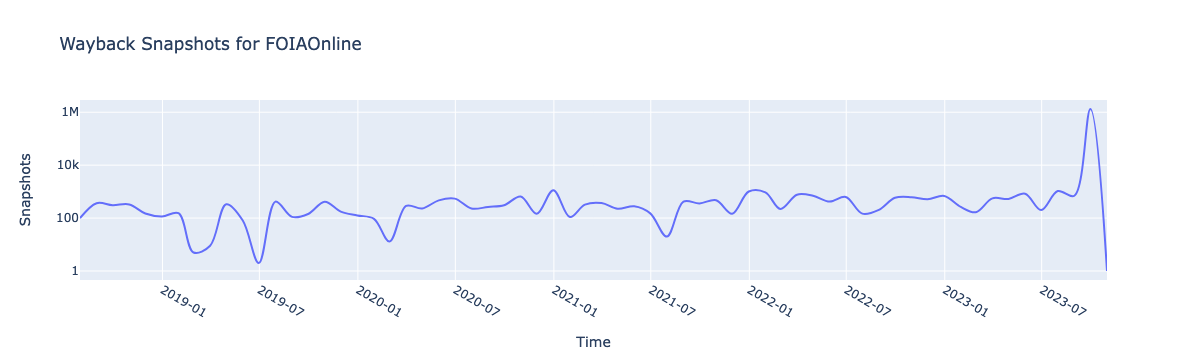

In [104]:
from plotly import express as px

monthly_counts = snapshots.set_index('timestamp').resample('M').agg('count')

fig = px.line(
    monthly_counts, 
    log_y=True,
    labels={'value': 'Snapshots', 'timestamp': 'Time'}, 
    title='Wayback Snapshots for FOIAOnline',
    line_shape='spline'
)

fig = fig.update_layout(
    showlegend=False,
    xaxis=dict(
        tickformat='%Y-%m', dtick='M6', tickangle=30,
    )
)

fig.show()

Perhaps unsuprisingly the majority of the data collection happened in September, 2023. Looking at some of the snpahots it's pretty clear that [Archive Team](https://archiveteam.org) have been working to do this data collection. More about this effort can be found on [this wiki page](https://wiki.archiveteam.org/index.php/FOIAonline). It's possible that more data that was collected is still being loaded?

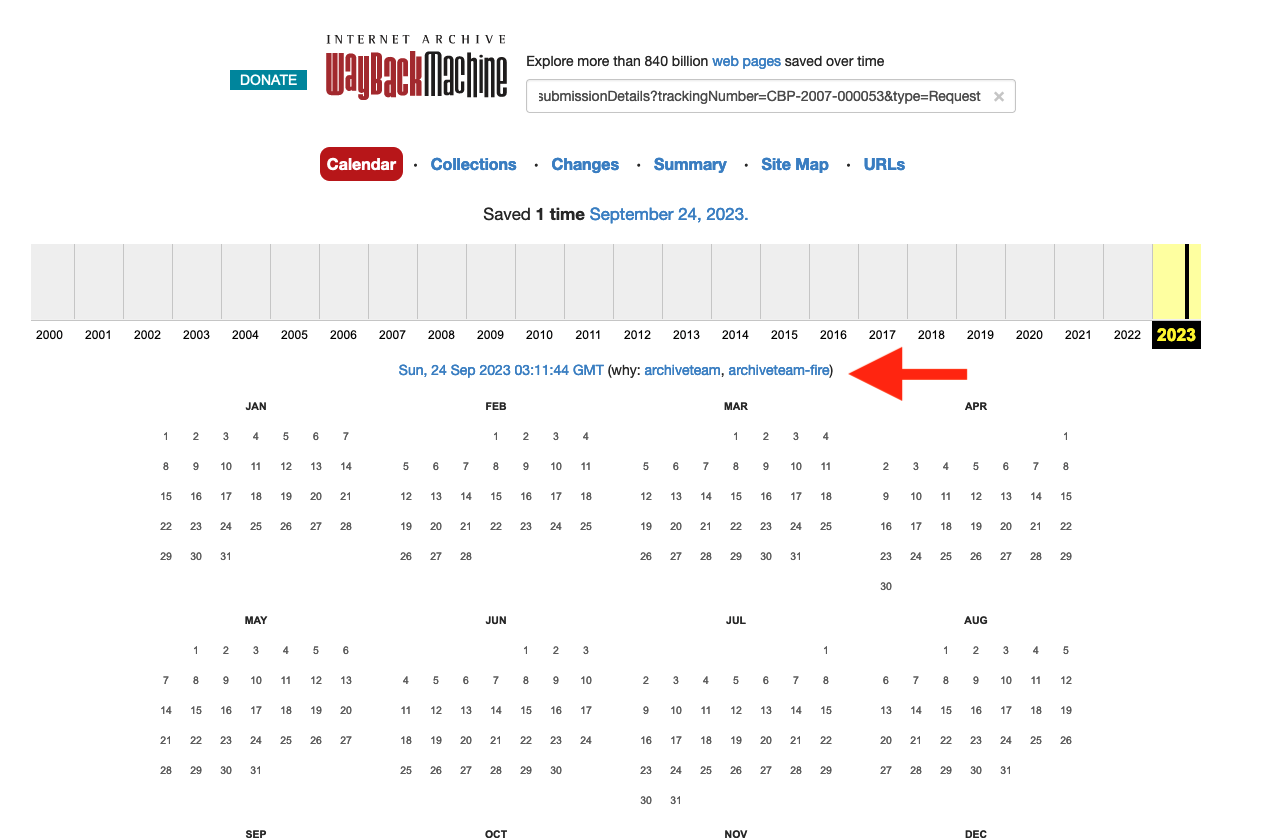